This is my solution the exercise https://www.kaggle.com/competitions/titanic/, which I am writing to learn about machine learning.

Copyright (C) 2022 Chris March <https://github.com/chrismarch>

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

## Contents
- [Load and Preprocess](#Load-and-Preprocess)
- [Training](#Training)
- [Scoring](#Scoring)
- [Tuning](#Tuning)
- [Submission](#Submission)

## Load and Preprocess

In [456]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin
import re

def load_csv_as_pd(csv_filename, data_path="."):
    csv_path = os.path.join(data_path, csv_filename)
    return pd.read_csv(csv_path)

class RegExTransformer(TransformerMixin):
    def __init__(self, col_idxs_to_regexes=[]): # no *args or **kargs
        self.col_idxs_to_regexes = col_idxs_to_regexes
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, Xdf):
        result = Xdf.copy()
        for col_idx_and_regex in self.col_idxs_to_regexes:
            col_idx = col_idx_and_regex[0]
            r = col_idx_and_regex[1]
            #print(result[:,col_idx])
            #print(result[0][col_idx])
            #print(r.search(result[0][col_idx]).group(0))
            new_result = []
            for row in result[col_idx]:
                title = r.search(str(row))
                title = title.group(0) if title else None
                new_result.append(title)
            #print(new_result)
            result[col_idx] = new_result
        return result

rc_name = re.compile(r"[\w]+(?=\.)")
rc_ticket = re.compile(r"(\d+)(?!.*\d)")
re_cat_tr = RegExTransformer(col_idxs_to_regexes=[("Name", rc_name)])
re_num_tr = RegExTransformer(col_idxs_to_regexes=[("Ticket", rc_ticket)])


def preprocess_data(data):    
    drop_attribs = ['PassengerId', "Cabin"]
    pp = data.drop(drop_attribs, axis=1)
    return re_cat_tr.transform(pp)
    
all_train_data = load_csv_as_pd("train.csv")
all_train_data_pp = preprocess_data(all_train_data)

name_set = set(all_train_data_pp["Name"])
name_set.add('Dona') # test.csv only
name_categories = list(name_set)
sex_categories = list(set(all_train_data_pp["Sex"]))
embarked_categories = list(set(all_train_data_pp["Embarked"]))
all_categories = [name_categories, sex_categories, embarked_categories]
print(all_categories)
                                
target_label_col = "Survived"
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_indexes, test_indexes in split.split(all_train_data_pp, all_train_data_pp[target_label_col]):
    strat_train_set = all_train_data_pp.loc[train_indexes]
    strat_test_set = all_train_data_pp.loc[test_indexes]

#strat_test_set["income_cat"].value_counts() / len(strat_test_set)

print(list(strat_train_set))
X_train = strat_train_set.drop(target_label_col, axis=1)
y_train = strat_train_set[target_label_col].copy()

# test data split from train.csv, since test.csv has no labels
X_test = strat_test_set.drop(target_label_col, axis=1)
y_test = strat_test_set[target_label_col].copy()

print(X_train.shape)
X_train.iloc[0]
X_train["Name"]

[['Miss', 'Mr', 'Lady', 'Mrs', 'Ms', 'Don', 'Capt', 'Rev', 'Mlle', 'Jonkheer', 'Dona', 'Master', 'Mme', 'Col', 'Dr', 'Major', 'Sir', 'Countess'], ['male', 'female'], ['Q', 'C', 'S', nan]]
['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']
(712, 9)


692      Mr
481      Mr
527      Mr
855     Mrs
801     Mrs
       ... 
359    Miss
258    Miss
736     Mrs
462      Mr
507      Mr
Name: Name, Length: 712, dtype: object

## Correlation Exploration

In [374]:
drop_attribs_cor = ["PassengerId", "Cabin"] # FIXME parse Cabin?
X_cor = train.drop(drop_attribs_cor, axis=1)
print(list(X_cor))
num_attribs_cor = ['Survived', 'Pclass', "Ticket", 'Age', 'SibSp', 'Parch', 'Fare']
cat_attribs_cor = ["Name", 'Sex', 'Embarked']


['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']


In [262]:
X_re = re_num_tr.transform(re_cat_tr.transform(X_cor))
print(X_re)

     Survived  Pclass  Name     Sex   Age  SibSp  Parch   Ticket     Fare  \
0           0       3    Mr    male  22.0      1      0    21171   7.2500   
1           1       1   Mrs  female  38.0      1      0    17599  71.2833   
2           1       3  Miss  female  26.0      0      0  3101282   7.9250   
3           1       1   Mrs  female  35.0      1      0   113803  53.1000   
4           0       3    Mr    male  35.0      0      0   373450   8.0500   
..        ...     ...   ...     ...   ...    ...    ...      ...      ...   
886         0       2   Rev    male  27.0      0      0   211536  13.0000   
887         1       1  Miss  female  19.0      0      0   112053  30.0000   
888         0       3  Miss  female   NaN      1      2     6607  23.4500   
889         1       1    Mr    male  26.0      0      0   111369  30.0000   
890         0       3    Mr    male  32.0      0      0   370376   7.7500   

    Embarked  
0          S  
1          C  
2          S  
3          S  


In [375]:
num_pipe_cor = Pipeline([
        ('regex', re_num_tr),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipe_cor = Pipeline([    
        ('one', OneHotEncoder(categories=all_categories)),
    ])

col_trans_cor = ColumnTransformer([
        ("num", num_pipe_cor, num_attribs_cor),
        ("cat", cat_pipe_cor, cat_attribs_cor),
    ])

col_trans_cor.fit(X_cor, y_train)

ValueError: Found unknown categories ['Sutehall, Mr. Henry Jr', 'Harmer, Mr. Abraham (David Lishin)', 'Farthing, Mr. John', 'Stephenson, Mrs. Walter Bertram (Martha Eustis)', 'Kent, Mr. Edward Austin', 'McDermott, Miss. Brigdet Delia', 'Barber, Miss. Ellen "Nellie"', 'Hart, Mr. Henry', 'Hocking, Mr. Richard George', 'Moussa, Mrs. (Mantoura Boulos)', 'Moor, Mrs. (Beila)', 'Honkanen, Miss. Eliina', 'Staneff, Mr. Ivan', 'O\'Dwyer, Miss. Ellen "Nellie"', 'Spencer, Mrs. William Augustus (Marie Eugenie)', 'Sheerlinck, Mr. Jan Baptist', 'Strom, Miss. Telma Matilda', 'Romaine, Mr. Charles Hallace ("Mr C Rolmane")', 'Taylor, Mrs. Elmer Zebley (Juliet Cummins Wright)', 'Watson, Mr. Ennis Hastings', 'Danoff, Mr. Yoto', 'Chronopoulos, Mr. Apostolos', 'Johnson, Mr. Malkolm Joackim', 'Frolicher-Stehli, Mr. Maxmillian', 'Kraeff, Mr. Theodor', 'Harper, Miss. Annie Jessie "Nina"', 'Chibnall, Mrs. (Edith Martha Bowerman)', 'Laroche, Mr. Joseph Philippe Lemercier', 'Emanuel, Miss. Virginia Ethel', 'del Carlo, Mr. Sebastiano', 'Healy, Miss. Hanora "Nora"', 'Richard, Mr. Emile', 'Widegren, Mr. Carl/Charles Peter', 'Samaan, Mr. Youssef', 'Jacobsohn, Mrs. Sidney Samuel (Amy Frances Christy)', 'Somerton, Mr. Francis William', 'Mitchell, Mr. Henry Michael', 'Cann, Mr. Ernest Charles', 'Strandberg, Miss. Ida Sofia', 'Dooley, Mr. Patrick', 'Mernagh, Mr. Robert', 'Bourke, Mr. John', 'Shellard, Mr. Frederick William', 'Fortune, Miss. Mabel Helen', 'Hagland, Mr. Konrad Mathias Reiersen', 'Ridsdale, Miss. Lucy', 'Goodwin, Master. Harold Victor', 'Coutts, Master. Eden Leslie "Neville"', 'Hays, Miss. Margaret Bechstein', 'Elsbury, Mr. William James', 'Chambers, Mr. Norman Campbell', 'Barah, Mr. Hanna Assi', 'Laitinen, Miss. Kristina Sofia', 'Birkeland, Mr. Hans Martin Monsen', 'Dennis, Mr. Samuel', 'Andersson, Mr. Anders Johan', 'Ford, Mr. William Neal', 'Sundman, Mr. Johan Julian', 'Cacic, Mr. Luka', 'Bateman, Rev. Robert James', 'Turkula, Mrs. (Hedwig)', 'de Messemaeker, Mrs. Guillaume Joseph (Emma)', 'Holverson, Mrs. Alexander Oskar (Mary Aline Towner)', 'Young, Miss. Marie Grice', 'Oreskovic, Miss. Marija', 'Moubarek, Master. Gerios', 'Bracken, Mr. James H', 'Hoyt, Mr. Frederick Maxfield', 'Youseff, Mr. Gerious', 'Hays, Mrs. Charles Melville (Clara Jennings Gregg)', 'Rice, Master. Eugene', 'Petroff, Mr. Nedelio', 'Lievens, Mr. Rene Aime', 'Peduzzi, Mr. Joseph', 'Abbing, Mr. Anthony', 'Najib, Miss. Adele Kiamie "Jane"', 'Kalvik, Mr. Johannes Halvorsen', 'Blank, Mr. Henry', 'Ohman, Miss. Velin', 'Meyer, Mr. August', 'Asim, Mr. Adola', 'Pears, Mr. Thomas Clinton', 'Cairns, Mr. Alexander', 'Strom, Mrs. Wilhelm (Elna Matilda Persson)', 'Rosblom, Mrs. Viktor (Helena Wilhelmina)', 'Thayer, Mrs. John Borland (Marian Longstreth Morris)', 'Willey, Mr. Edward', 'Coutts, Master. William Loch "William"', 'Thayer, Mr. John Borland Jr', 'Ryan, Mr. Patrick', 'Chip, Mr. Chang', 'Kenyon, Mrs. Frederick R (Marion)', 'Mayne, Mlle. Berthe Antonine ("Mrs de Villiers")', 'Reeves, Mr. David', 'Ponesell, Mr. Martin', 'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)', 'Sage, Miss. Stella Anna', 'Hart, Miss. Eva Miriam', 'Gaskell, Mr. Alfred', 'Campbell, Mr. William', 'Gustafsson, Mr. Johan Birger', 'Harknett, Miss. Alice Phoebe', 'Keefe, Mr. Arthur', 'Richards, Master. George Sibley', 'Leyson, Mr. Robert William Norman', 'Levy, Mr. Rene Jacques', 'Pain, Dr. Alfred', 'Olsen, Mr. Henry Margido', 'Hocking, Mrs. Elizabeth (Eliza Needs)', 'Andersson, Master. Sigvard Harald Elias', 'Angle, Mrs. William A (Florence "Mary" Agnes Hughes)', 'Rice, Master. Eric', 'Shelley, Mrs. William (Imanita Parrish Hall)', 'Hedman, Mr. Oskar Arvid', 'Sjoblom, Miss. Anna Sofia', 'Bystrom, Mrs. (Karolina)', 'Flynn, Mr. James', 'Nasser, Mrs. Nicholas (Adele Achem)', 'Ford, Miss. Robina Maggie "Ruby"', 'Peter, Miss. Anna', 'Nicholson, Mr. Arthur Ernest', 'Carter, Mrs. William Ernest (Lucile Polk)', 'Lemberopolous, Mr. Peter L', 'Laroche, Miss. Simonne Marie Anne Andree', 'Stoytcheff, Mr. Ilia', 'Mitkoff, Mr. Mito', 'Collyer, Mrs. Harvey (Charlotte Annie Tate)', 'Butler, Mr. Reginald Fenton', 'Coelho, Mr. Domingos Fernandeo', 'Celotti, Mr. Francesco', 'Corn, Mr. Harry', 'Gronnestad, Mr. Daniel Danielsen', 'Long, Mr. Milton Clyde', 'Jussila, Miss. Katriina', 'Gill, Mr. John William', 'White, Mr. Percival Wayland', 'Augustsson, Mr. Albert', 'Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)', 'Carr, Miss. Helen "Ellen"', 'Jermyn, Miss. Annie', 'McCoy, Miss. Agnes', 'Duran y More, Miss. Asuncion', 'Razi, Mr. Raihed', 'Meo, Mr. Alfonzo', 'Hickman, Mr. Stanley George', 'Hakkarainen, Mr. Pekka Pietari', 'Olsson, Miss. Elina', 'Marechal, Mr. Pierre', 'Allison, Miss. Helen Loraine', 'Petterson, Mr. Johan Emil', "O'Driscoll, Miss. Bridget", 'Tobin, Mr. Roger', 'Murphy, Miss. Katherine "Kate"', 'Widener, Mr. Harry Elkins', 'Byles, Rev. Thomas Roussel Davids', 'Coleff, Mr. Peju', 'Drazenoic, Mr. Jozef', 'Ward, Miss. Anna', 'Swift, Mrs. Frederick Joel (Margaret Welles Barron)', 'Newell, Mr. Arthur Webster', 'Otter, Mr. Richard', 'Barbara, Mrs. (Catherine David)', 'Christmann, Mr. Emil', 'Shorney, Mr. Charles Joseph', 'Givard, Mr. Hans Kristensen', 'Danbom, Mr. Ernst Gilbert', 'Stahelin-Maeglin, Dr. Max', 'Rogers, Mr. William John', 'Nysten, Miss. Anna Sofia', 'Lovell, Mr. John Hall ("Henry")', 'Meyer, Mr. Edgar Joseph', 'Pickard, Mr. Berk (Berk Trembisky)', 'Yousif, Mr. Wazli', 'Pavlovic, Mr. Stefo', 'Perreault, Miss. Anne', 'Abelson, Mr. Samuel', 'Rice, Master. Arthur', 'Denkoff, Mr. Mitto', 'Olsvigen, Mr. Thor Anderson', 'Tornquist, Mr. William Henry', 'Leonard, Mr. Lionel', 'Becker, Miss. Marion Louise', 'Mudd, Mr. Thomas Charles', "O'Connell, Mr. Patrick D", 'Moran, Mr. Daniel J', 'Sdycoff, Mr. Todor', 'Richards, Mrs. Sidney (Emily Hocking)', 'Alexander, Mr. William', 'McKane, Mr. Peter David', 'Hansen, Mr. Claus Peter', 'Harder, Mr. George Achilles', 'Cribb, Mr. John Hatfield', 'Rothschild, Mrs. Martin (Elizabeth L. Barrett)', 'Mangan, Miss. Mary', 'Bourke, Miss. Mary', 'Trout, Mrs. William H (Jessie L)', 'Hendekovic, Mr. Ignjac', 'Hanna, Mr. Mansour', 'Nicholls, Mr. Joseph Charles', 'Leinonen, Mr. Antti Gustaf', 'Nasser, Mr. Nicholas', 'Lefebre, Miss. Ida', 'Zimmerman, Mr. Leo', "O'Connor, Mr. Maurice", 'Kassem, Mr. Fared', 'Ryerson, Miss. Emily Borie', 'Stanley, Miss. Amy Zillah Elsie', 'West, Miss. Constance Mirium', 'Davies, Mr. Alfred J', 'Panula, Mrs. Juha (Maria Emilia Ojala)', 'Svensson, Mr. Johan', 'Gustafsson, Mr. Alfred Ossian', 'Mionoff, Mr. Stoytcho', 'Calderhead, Mr. Edward Pennington', 'Millet, Mr. Francis Davis', 'Longley, Miss. Gretchen Fiske', 'Devaney, Miss. Margaret Delia', 'Lennon, Mr. Denis', 'Adahl, Mr. Mauritz Nils Martin', 'Backstrom, Mrs. Karl Alfred (Maria Mathilda Gustafsson)', 'Nakid, Miss. Maria ("Mary")', 'Allen, Miss. Elisabeth Walton', 'Dahlberg, Miss. Gerda Ulrika', 'Rouse, Mr. Richard Henry', 'Beesley, Mr. Lawrence', 'Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)', 'Dahl, Mr. Karl Edwart', 'Gustafsson, Mr. Karl Gideon', 'Greenfield, Mr. William Bertram', 'Sage, Mr. Frederick', 'Abbott, Mrs. Stanton (Rosa Hunt)', 'Carbines, Mr. William', 'Edvardsson, Mr. Gustaf Hjalmar', 'Harrison, Mr. William', 'Vander Planke, Mr. Leo Edmondus', 'Giglio, Mr. Victor', 'Webber, Mr. James', 'Murdlin, Mr. Joseph', 'Johnson, Master. Harold Theodor', 'Andrews, Mr. Thomas Jr', 'Tikkanen, Mr. Juho', 'Brown, Mrs. James Joseph (Margaret Tobin)', 'Goldenberg, Mrs. Samuel L (Edwiga Grabowska)', 'Beckwith, Mr. Richard Leonard', 'Brocklebank, Mr. William Alfred', 'Duane, Mr. Frank', 'Thomas, Master. Assad Alexander', 'Eitemiller, Mr. George Floyd', 'Mellors, Mr. William John', 'Futrelle, Mrs. Jacques Heath (Lily May Peel)', 'Baumann, Mr. John D', 'Smith, Mr. Thomas', 'Molson, Mr. Harry Markland', 'Graham, Miss. Margaret Edith', 'Hart, Mrs. Benjamin (Esther Ada Bloomfield)', 'Sawyer, Mr. Frederick Charles', 'Markun, Mr. Johann', 'Newell, Miss. Marjorie', 'Gallagher, Mr. Martin', 'Niskanen, Mr. Juha', 'Boulos, Mr. Hanna', 'Shutes, Miss. Elizabeth W', 'Flynn, Mr. John Irwin ("Irving")', 'Parrish, Mrs. (Lutie Davis)', 'Mineff, Mr. Ivan', 'Reynaldo, Ms. Encarnacion', 'Caldwell, Master. Alden Gates', 'Gilinski, Mr. Eliezer', 'Peuchen, Major. Arthur Godfrey', 'Jalsevac, Mr. Ivan', 'Hamalainen, Master. Viljo', 'Phillips, Miss. Kate Florence ("Mrs Kate Louise Phillips Marshall")', 'Coxon, Mr. Daniel', 'Padro y Manent, Mr. Julian', 'Rommetvedt, Mr. Knud Paust', 'Bing, Mr. Lee', 'Knight, Mr. Robert J', 'Canavan, Miss. Mary', 'Moraweck, Dr. Ernest', 'Moore, Mr. Leonard Charles', 'Fischer, Mr. Eberhard Thelander', 'Butt, Major. Archibald Willingham', 'van Melkebeke, Mr. Philemon', 'Gheorgheff, Mr. Stanio', 'Behr, Mr. Karl Howell', 'Pengelly, Mr. Frederick William', 'Aks, Mrs. Sam (Leah Rosen)', 'Elias, Mr. Tannous', 'Kallio, Mr. Nikolai Erland', 'Bowerman, Miss. Elsie Edith', 'Cohen, Mr. Gurshon "Gus"', 'Goodwin, Miss. Lillian Amy', 'Moubarek, Master. Halim Gonios ("William George")', 'Chambers, Mrs. Norman Campbell (Bertha Griggs)', 'Slocovski, Mr. Selman Francis', 'Barbara, Miss. Saiide', 'Carter, Mr. William Ernest', 'Madigan, Miss. Margaret "Maggie"', 'Elias, Mr. Dibo', 'Natsch, Mr. Charles H', 'Bazzani, Miss. Albina', 'Foo, Mr. Choong', 'Frauenthal, Dr. Henry William', 'Moss, Mr. Albert Johan', 'Frost, Mr. Anthony Wood "Archie"', "O'Sullivan, Miss. Bridget Mary", 'Simmons, Mr. John', 'Heikkinen, Miss. Laina', 'Skoog, Master. Harald', 'Walker, Mr. William Anderson', 'Turja, Miss. Anna Sofia', 'Osen, Mr. Olaf Elon', 'Novel, Mr. Mansouer', 'Sage, Miss. Constance Gladys', 'Johansson, Mr. Erik', 'Farrell, Mr. James', 'Mockler, Miss. Helen Mary "Ellie"', 'Lewy, Mr. Ervin G', 'Gee, Mr. Arthur H', 'Allen, Mr. William Henry', 'Soholt, Mr. Peter Andreas Lauritz Andersen', 'Reuchlin, Jonkheer. John George', 'Rintamaki, Mr. Matti', 'Graham, Mrs. William Thompson (Edith Junkins)', 'Faunthorpe, Mrs. Lizzie (Elizabeth Anne Wilkinson)', 'Artagaveytia, Mr. Ramon', 'Foreman, Mr. Benjamin Laventall', 'Kelly, Miss. Anna Katherine "Annie Kate"', 'Weisz, Mrs. Leopold (Mathilde Francoise Pede)', 'Appleton, Mrs. Edward Dale (Charlotte Lamson)', 'Cherry, Miss. Gladys', 'Nysveen, Mr. Johan Hansen', 'Vande Velde, Mr. Johannes Joseph', 'Williams, Mr. Charles Duane', 'Wells, Miss. Joan', 'Graham, Mr. George Edward', 'Jerwan, Mrs. Amin S (Marie Marthe Thuillard)', 'Goldschmidt, Mr. George B', 'Windelov, Mr. Einar', 'Horgan, Mr. John', 'Norman, Mr. Robert Douglas', 'Turpin, Mrs. William John Robert (Dorothy Ann Wonnacott)', 'Madsen, Mr. Fridtjof Arne', 'Waelens, Mr. Achille', 'Lester, Mr. James', 'Carter, Mrs. Ernest Courtenay (Lilian Hughes)', 'Rosblom, Mr. Viktor Richard', 'Partner, Mr. Austen', 'Baclini, Miss. Eugenie', 'Vovk, Mr. Janko', 'Bailey, Mr. Percy Andrew', 'Cacic, Miss. Marija', 'Futrelle, Mr. Jacques Heath', 'Fahlstrom, Mr. Arne Jonas', 'Brown, Mr. Thomas William Solomon', 'Lang, Mr. Fang', 'McCarthy, Mr. Timothy J', 'Asplund, Miss. Lillian Gertrud', 'Smiljanic, Mr. Mile', 'Bengtsson, Mr. John Viktor', 'Aubart, Mme. Leontine Pauline', 'Mamee, Mr. Hanna', 'Toomey, Miss. Ellen', 'Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)', 'Kilgannon, Mr. Thomas J', 'Glynn, Miss. Mary Agatha', 'Beckwith, Mrs. Richard Leonard (Sallie Monypeny)', 'Newell, Miss. Madeleine', 'Attalah, Miss. Malake', 'Moran, Mr. James', 'Smith, Miss. Marion Elsie', 'Yasbeck, Mrs. Antoni (Selini Alexander)', 'Doling, Miss. Elsie', 'Ling, Mr. Lee', 'Lulic, Mr. Nikola', 'Ford, Miss. Doolina Margaret "Daisy"', 'Nosworthy, Mr. Richard Cater', 'Asplund, Master. Edvin Rojj Felix', 'Hart, Mr. Benjamin', 'Markoff, Mr. Marin', 'Watt, Mrs. James (Elizabeth "Bessie" Inglis Milne)', 'Abbott, Mr. Rossmore Edward', 'Dodge, Master. Washington', 'Emir, Mr. Farred Chehab', 'Collyer, Miss. Marjorie "Lottie"', 'Seward, Mr. Frederic Kimber', 'Goodwin, Mrs. Frederick (Augusta Tyler)', 'Stone, Mrs. George Nelson (Martha Evelyn)', 'Sirayanian, Mr. Orsen', 'Jacobsohn, Mr. Sidney Samuel', 'Slayter, Miss. Hilda Mary', 'Montvila, Rev. Juozas', 'Culumovic, Mr. Jeso', "O'Brien, Mr. Timothy", 'Saad, Mr. Amin', 'Adams, Mr. John', 'Carter, Rev. Ernest Courtenay', 'Panula, Mr. Jaako Arnold', 'Crosby, Miss. Harriet R', 'Ahlin, Mrs. Johan (Johanna Persdotter Larsson)', 'Bissette, Miss. Amelia', 'Andersson, Miss. Ellis Anna Maria', 'Morrow, Mr. Thomas Rowan', 'Daniel, Mr. Robert Williams', 'Hansen, Mr. Henrik Juul', 'Goldsmith, Mr. Frank John', 'Christy, Miss. Julie Rachel', 'Touma, Mrs. Darwis (Hanne Youssef Razi)', 'Andersson, Miss. Sigrid Elisabeth', 'Francatelli, Miss. Laura Mabel', 'Gustafsson, Mr. Anders Vilhelm', 'Goodwin, Mr. Charles Edward', 'Colley, Mr. Edward Pomeroy', 'Silverthorne, Mr. Spencer Victor', 'Beane, Mr. Edward', 'Taussig, Mrs. Emil (Tillie Mandelbaum)', 'Zabour, Miss. Thamine', 'Turpin, Mr. William John Robert', 'Bonnell, Miss. Elizabeth', 'Cook, Mr. Jacob', 'Isham, Miss. Ann Elizabeth', 'Svensson, Mr. Olof', 'Beane, Mrs. Edward (Ethel Clarke)', 'Taylor, Mr. Elmer Zebley', 'Jardin, Mr. Jose Neto', 'Yousseff, Mr. Gerious', 'O\'Leary, Miss. Hanora "Norah"', 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)', 'Gavey, Mr. Lawrence', 'Saalfeld, Mr. Adolphe', 'Larsson, Mr. Bengt Edvin', 'Boulos, Miss. Nourelain', 'Humblen, Mr. Adolf Mathias Nicolai Olsen', 'Panula, Master. Juha Niilo', 'Dick, Mrs. Albert Adrian (Vera Gillespie)', 'Allum, Mr. Owen George', 'Van Impe, Mr. Jean Baptiste', 'Vander Cruyssen, Mr. Victor', 'Garfirth, Mr. John', 'McGowan, Miss. Anna "Annie"', 'Fox, Mr. Stanley Hubert', 'Johnson, Mr. Alfred', 'Carter, Miss. Lucile Polk', 'Jensen, Mr. Svend Lauritz', 'Parkes, Mr. Francis "Frank"', 'Parr, Mr. William Henry Marsh', 'Palsson, Master. Gosta Leonard', 'Pasic, Mr. Jakob', 'Keane, Mr. Andrew "Andy"', 'Gilnagh, Miss. Katherine "Katie"', 'Fortune, Miss. Alice Elizabeth', 'Bowen, Mr. David John "Dai"', 'Robins, Mrs. Alexander A (Grace Charity Laury)', 'Carlsson, Mr. August Sigfrid', 'Chapman, Mr. Charles Henry', 'Nenkoff, Mr. Christo', 'Bryhl, Mr. Kurt Arnold Gottfrid', 'Hegarty, Miss. Hanora "Nora"', 'Andrews, Miss. Kornelia Theodosia', 'Davison, Mrs. Thomas Henry (Mary E Finck)', 'Jonkoff, Mr. Lalio', 'Pernot, Mr. Rene', 'Flynn, Mr. John', 'Kantor, Mr. Sinai', 'Sedgwick, Mr. Charles Frederick Waddington', 'Lahtinen, Mrs. William (Anna Sylfven)', 'Maenpaa, Mr. Matti Alexanteri', 'Rekic, Mr. Tido', 'Lindblom, Miss. Augusta Charlotta', 'Jansson, Mr. Carl Olof', 'Vande Walle, Mr. Nestor Cyriel', 'Connolly, Miss. Kate', 'Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson)', 'Pinsky, Mrs. (Rosa)', 'Dean, Mr. Bertram Frank', 'McMahon, Mr. Martin', 'Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengtsson)', 'Kelly, Mrs. Florence "Fannie"', 'Pears, Mrs. Thomas (Edith Wearne)', 'Lefebre, Miss. Jeannie', 'Stewart, Mr. Albert A', 'Goodwin, Master. Sidney Leonard', 'Lehmann, Miss. Bertha', 'Ball, Mrs. (Ada E Hall)', 'Cor, Mr. Liudevit', 'Jussila, Miss. Mari Aina', 'Wiseman, Mr. Phillippe', 'Robert, Mrs. Edward Scott (Elisabeth Walton McMillan)', 'Compton, Miss. Sara Rebecca', 'Alhomaki, Mr. Ilmari Rudolf', 'Sutton, Mr. Frederick', 'Dakic, Mr. Branko', 'Navratil, Master. Michel M', 'Sjostedt, Mr. Ernst Adolf', 'Fortune, Mr. Mark', 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)', 'Hippach, Miss. Jean Gertrude', 'Johansson, Mr. Gustaf Joel', 'Ali, Mr. Ahmed', 'Ford, Mrs. Edward (Margaret Ann Watson)', 'Calic, Mr. Jovo', 'Larsson, Mr. August Viktor', 'de Pelsmaeker, Mr. Alfons', 'Skoog, Miss. Margit Elizabeth', 'Cleaver, Miss. Alice', 'Sandstrom, Miss. Marguerite Rut', 'Ilmakangas, Miss. Pieta Sofia', 'Doling, Mrs. John T (Ada Julia Bone)', 'Maisner, Mr. Simon', 'Andrew, Mr. Edgardo Samuel', 'Herman, Miss. Alice', 'Nilsson, Miss. Helmina Josefina', 'Quick, Mrs. Frederick Charles (Jane Richards)', 'Minahan, Dr. William Edward', 'McGovern, Miss. Mary', 'Cunningham, Mr. Alfred Fleming', 'Icard, Miss. Amelie', 'Brewe, Dr. Arthur Jackson', 'Cardeza, Mr. Thomas Drake Martinez', 'Masselmani, Mrs. Fatima', 'Karaic, Mr. Milan', 'Mullens, Miss. Katherine "Katie"', 'Andreasson, Mr. Paul Edvin', 'Navratil, Master. Edmond Roger', 'Wright, Mr. George', 'Torber, Mr. Ernst William', 'Navratil, Mr. Michel ("Louis M Hoffman")', 'Reed, Mr. James George', 'Caldwell, Mrs. Albert Francis (Sylvia Mae Harbaugh)', 'Nicola-Yarred, Miss. Jamila', 'Pekoniemi, Mr. Edvard', 'Collander, Mr. Erik Gustaf', 'Myhrman, Mr. Pehr Fabian Oliver Malkolm', 'Hawksford, Mr. Walter James', 'Patchett, Mr. George', 'Jensen, Mr. Hans Peder', 'Ivanoff, Mr. Kanio', 'Arnold-Franchi, Mrs. Josef (Josefine Franchi)', 'Harper, Mrs. Henry Sleeper (Myna Haxtun)', 'Williams, Mr. Charles Eugene', 'Fortune, Mr. Charles Alexander', 'Beavan, Mr. William Thomas', 'Nye, Mrs. (Elizabeth Ramell)', 'Holverson, Mr. Alexander Oskar', 'Sage, Mr. George John Jr', 'Fleming, Miss. Margaret', 'Harris, Mr. Walter', 'Hassan, Mr. Houssein G N', 'Lefebre, Miss. Mathilde', 'Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")', 'Palsson, Miss. Torborg Danira', 'Panula, Mr. Ernesti Arvid', 'Caram, Mrs. Joseph (Maria Elias)', 'Hirvonen, Miss. Hildur E', 'Bourke, Mrs. John (Catherine)', 'Uruchurtu, Don. Manuel E', 'Sivola, Mr. Antti Wilhelm', 'Kelly, Miss. Mary', 'van Billiard, Mr. Austin Blyler', 'Mellinger, Mrs. (Elizabeth Anne Maidment)', 'Jussila, Mr. Eiriik', 'Drew, Mrs. James Vivian (Lulu Thorne Christian)', 'Lindqvist, Mr. Eino William', 'Roebling, Mr. Washington Augustus II', 'Rice, Master. George Hugh', 'Meanwell, Miss. (Marion Ogden)', 'Harrington, Mr. Charles H', 'Weir, Col. John', 'Andersson, Mr. August Edvard ("Wennerstrom")', 'Robbins, Mr. Victor', 'Troupiansky, Mr. Moses Aaron', 'Ibrahim Shawah, Mr. Yousseff', 'Harper, Rev. John', 'Penasco y Castellana, Mr. Victor de Satode', 'Attalah, Mr. Sleiman', 'Nakid, Mr. Sahid', 'Johnston, Miss. Catherine Helen "Carrie"', 'Charters, Mr. David', 'Connors, Mr. Patrick', 'Herman, Mrs. Samuel (Jane Laver)', 'Persson, Mr. Ernst Ulrik', 'Morley, Mr. Henry Samuel ("Mr Henry Marshall")', 'Dean, Master. Bertram Vere', 'Hickman, Mr. Lewis', 'Oreskovic, Mr. Luka', 'Renouf, Mr. Peter Henry', 'Rush, Mr. Alfred George John', 'Sage, Mr. Douglas Bullen', 'Jensen, Mr. Niels Peder', 'Goldsmith, Master. Frank John William "Frankie"', 'Gale, Mr. Shadrach', 'Panula, Master. Eino Viljami', 'Scanlan, Mr. James', 'Peter, Mrs. Catherine (Catherine Rizk)', 'Lefebre, Master. Henry Forbes', 'Boulos, Mrs. Joseph (Sultana)', 'Maioni, Miss. Roberta', 'Badt, Mr. Mohamed', 'West, Mrs. Edwy Arthur (Ada Mary Worth)', 'Lobb, Mrs. William Arthur (Cordelia K Stanlick)', 'Petroff, Mr. Pastcho ("Pentcho")', 'Hunt, Mr. George Henry', 'Williams, Mr. Leslie', 'Giles, Mr. Frederick Edward', 'Laleff, Mr. Kristo', 'Spedden, Mrs. Frederic Oakley (Margaretta Corning Stone)', 'Wiklund, Mr. Jakob Alfred', 'Jonsson, Mr. Carl', 'Lines, Miss. Mary Conover', 'Davies, Master. John Morgan Jr', 'LeRoy, Miss. Bertha', 'Eustis, Miss. Elizabeth Mussey', 'Barton, Mr. David John', 'Chaffee, Mr. Herbert Fuller', 'Hold, Mr. Stephen', 'Kelly, Mr. James', 'Blackwell, Mr. Stephen Weart', 'Baclini, Miss. Helene Barbara', 'Douglas, Mr. Walter Donald', 'Osman, Mrs. Mara', 'O\'Brien, Mrs. Thomas (Johanna "Hannah" Godfrey)', 'Bishop, Mrs. Dickinson H (Helen Walton)', 'Turcin, Mr. Stjepan', 'Vander Planke, Miss. Augusta Maria', 'Kantor, Mrs. Sinai (Miriam Sternin)', 'Bjornstrom-Steffansson, Mr. Mauritz Hakan', 'Eklund, Mr. Hans Linus', 'Lam, Mr. Ali', 'Daly, Mr. Eugene Patrick', 'Sobey, Mr. Samuel James Hayden', 'Williams-Lambert, Mr. Fletcher Fellows', 'Van Impe, Mrs. Jean Baptiste (Rosalie Paula Govaert)', 'Tomlin, Mr. Ernest Portage', 'Lurette, Miss. Elise', 'Ali, Mr. William', 'Chapman, Mr. John Henry', 'Lobb, Mr. William Arthur', 'Thorneycroft, Mr. Percival', 'Kiernan, Mr. Philip', 'McCoy, Mr. Bernard', 'Clarke, Mrs. Charles V (Ada Maria Winfield)', 'Cavendish, Mr. Tyrell William', 'Slemen, Mr. Richard James', 'Theobald, Mr. Thomas Leonard', 'Becker, Master. Richard F', 'Hood, Mr. Ambrose Jr', 'Astor, Mrs. John Jacob (Madeleine Talmadge Force)', 'Mallet, Master. Andre', 'Sirota, Mr. Maurice', 'Rood, Mr. Hugh Roscoe', 'Arnold-Franchi, Mr. Josef', 'Albimona, Mr. Nassef Cassem', 'Peters, Miss. Katie', 'Harris, Mr. Henry Birkhardt', 'Betros, Mr. Tannous', 'Bradley, Mr. George ("George Arthur Brayton")', 'Dimic, Mr. Jovan', 'Goldenberg, Mr. Samuel L', 'de Mulder, Mr. Theodore', 'Goldsmith, Mrs. Frank John (Emily Alice Brown)', 'Laroche, Mrs. Joseph (Juliette Marie Louise Lafargue)', 'Karun, Miss. Manca', 'Sage, Miss. Dorothy Edith "Dolly"', 'Allison, Master. Hudson Trevor', 'Madill, Miss. Georgette Alexandra', 'Sadlier, Mr. Matthew', 'Frauenthal, Mrs. Henry William (Clara Heinsheimer)', 'Marvin, Mr. Daniel Warner', 'Ayoub, Miss. Banoura', 'Olsen, Mr. Karl Siegwart Andreas', 'Andersson, Mrs. Anders Johan (Alfrida Konstantia Brogren)', 'Morley, Mr. William', 'Elias, Mr. Joseph Jr', 'Greenberg, Mr. Samuel', 'Henry, Miss. Delia', 'Cameron, Miss. Clear Annie', 'McEvoy, Mr. Michael', 'Hickman, Mr. Leonard Mark', 'McGough, Mr. James Robert', 'Harris, Mrs. Henry Birkhardt (Irene Wallach)', 'Goodwin, Master. William Frederick', 'Mallet, Mr. Albert', 'Calic, Mr. Petar', 'Harris, Mr. George', 'Funk, Miss. Annie Clemmer', 'Jarvis, Mr. John Denzil', 'Carlsson, Mr. Frans Olof', 'Wick, Miss. Mary Natalie', 'McNamee, Mr. Neal', 'Woolner, Mr. Hugh', 'Berriman, Mr. William John', 'Silvey, Mr. William Baird', 'Skoog, Miss. Mabel', 'Louch, Mrs. Charles Alexander (Alice Adelaide Slow)', 'Van der hoef, Mr. Wyckoff', 'Thorne, Mrs. Gertrude Maybelle', 'Balkic, Mr. Cerin', 'Crosby, Capt. Edward Gifford', 'Davidson, Mr. Thornton', 'Kink, Mr. Vincenz', 'Stead, Mr. William Thomas', 'Braund, Mr. Lewis Richard', 'Lesurer, Mr. Gustave J', 'Johansson, Mr. Karl Johan', 'Johnson, Mr. William Cahoone Jr', 'Warren, Mrs. Frank Manley (Anna Sophia Atkinson)', 'Palsson, Miss. Stina Viola', 'Sharp, Mr. Percival James R', 'Landergren, Miss. Aurora Adelia', 'Heininen, Miss. Wendla Maria', 'Coleff, Mr. Satio', 'Banfield, Mr. Frederick James', 'Davies, Mr. Charles Henry', 'Klasen, Mr. Klas Albin', 'Richards, Master. William Rowe', 'Mellinger, Miss. Madeleine Violet', 'Olsen, Mr. Ole Martin', 'Sagesser, Mlle. Emma', 'Kimball, Mr. Edwin Nelson Jr', 'Johnston, Mr. Andrew G', 'Pettersson, Miss. Ellen Natalia', 'Carter, Master. William Thornton II', 'Ringhini, Mr. Sante', "O'Brien, Mr. Thomas", 'Rice, Mrs. William (Margaret Norton)', 'Bidois, Miss. Rosalie', 'Yrois, Miss. Henriette ("Mrs Harbeck")', 'Moen, Mr. Sigurd Hansen', 'Hosono, Mr. Masabumi', 'Hampe, Mr. Leon', 'Hogeboom, Mrs. John C (Anna Andrews)', 'Slabenoff, Mr. Petco', 'Troutt, Miss. Edwina Celia "Winnie"', 'Hale, Mr. Reginald', 'Moor, Master. Meier', 'Panula, Master. Urho Abraham', 'Skoog, Master. Karl Thorsten', 'Dantcheff, Mr. Ristiu', 'Carrau, Mr. Francisco M', 'Skoog, Mr. Wilhelm', 'Leitch, Miss. Jessie Wills', 'Smith, Mr. James Clinch', 'Hamalainen, Mrs. William (Anna)', 'Paulner, Mr. Uscher', 'Lindell, Mr. Edvard Bengtsson', 'Sivic, Mr. Husein', 'Burns, Miss. Elizabeth Margaret', 'Ilett, Miss. Bertha', 'Baclini, Miss. Marie Catherine', 'Hippach, Mrs. Louis Albert (Ida Sophia Fischer)', 'Andersson, Miss. Ebba Iris Alfrida', 'Johnson, Miss. Eleanor Ileen', 'Johanson, Mr. Jakob Alfred', 'Lindahl, Miss. Agda Thorilda Viktoria', 'Baxter, Mrs. James (Helene DeLaudeniere Chaput)', 'Wheadon, Mr. Edward H', 'Sloper, Mr. William Thompson', 'Salonen, Mr. Johan Werner', 'Petranec, Miss. Matilda', 'Klaber, Mr. Herman', 'Brown, Miss. Amelia "Mildred"', 'Lemore, Mrs. (Amelia Milley)', 'Leeni, Mr. Fahim ("Philip Zenni")', 'Buss, Miss. Kate', 'Barkworth, Mr. Algernon Henry Wilson', 'Harper, Mr. Henry Sleeper', 'Holm, Mr. John Fredrik Alexander', 'Wick, Mrs. George Dennick (Mary Hitchcock)', 'Clifford, Mr. George Quincy', 'Saundercock, Mr. William Henry', 'Backstrom, Mr. Karl Alfred', 'Dorking, Mr. Edward Arthur', 'Lundahl, Mr. Johan Svensson', 'Renouf, Mrs. Peter Henry (Lillian Jefferys)', 'Ryerson, Miss. Susan Parker "Suzette"', 'Coleridge, Mr. Reginald Charles', 'Danbom, Mrs. Ernst Gilbert (Anna Sigrid Maria Brogren)', 'Smart, Mr. John Montgomery', 'Anderson, Mr. Harry', 'Hewlett, Mrs. (Mary D Kingcome) ', 'Milling, Mr. Jacob Christian', 'Serepeca, Miss. Augusta', 'Homer, Mr. Harry ("Mr E Haven")', 'Doharr, Mr. Tannous', 'West, Mr. Edwy Arthur', 'Mack, Mrs. (Mary)', 'Rugg, Miss. Emily', 'Nankoff, Mr. Minko', 'Hansen, Mr. Henry Damsgaard', 'Webber, Miss. Susan', 'Taussig, Miss. Ruth', 'Nicola-Yarred, Master. Elias', 'Meek, Mrs. Thomas (Annie Louise Rowley)', 'Perkin, Mr. John Henry', 'Stanley, Mr. Edward Roland', 'Haas, Miss. Aloisia', 'Johannesen-Bratthammer, Mr. Bernt', 'Connaghton, Mr. Michael', 'Silvey, Mrs. William Baird (Alice Munger)', 'Daly, Mr. Peter Denis ', 'Andersson, Miss. Ingeborg Constanzia', 'Quick, Miss. Phyllis May', 'Sinkkonen, Miss. Anna', 'Green, Mr. George Henry', 'Smith, Mr. Richard William', 'Stankovic, Mr. Ivan', 'Dick, Mr. Albert Adrian', 'Todoroff, Mr. Lalio', 'Salkjelsvik, Miss. Anna Kristine', 'Kvillner, Mr. Johan Henrik Johannesson', 'Duff Gordon, Lady. (Lucille Christiana Sutherland) ("Mrs Morgan")', 'Collyer, Mr. Harvey', 'Sunderland, Mr. Victor Francis', 'Williams, Mr. Howard Hugh "Harry"', 'Minahan, Miss. Daisy E', 'Radeff, Mr. Alexander', 'Hakkarainen, Mrs. Pekka Pietari (Elin Matilda Dolck)', 'Sage, Master. Thomas Henry', 'Naidenoff, Mr. Penko', 'Skoog, Mrs. William (Anna Bernhardina Karlsson)', 'Ekstrom, Mr. Johan', 'Brown, Mrs. Thomas William Solomon (Elizabeth Catherine Ford)', 'Crease, Mr. Ernest James', 'Simonius-Blumer, Col. Oberst Alfons', 'Keane, Miss. Nora A', 'Allison, Mrs. Hudson J C (Bessie Waldo Daniels)', 'Berglund, Mr. Karl Ivar Sven', 'Odahl, Mr. Nils Martin', 'Lahoud, Mr. Sarkis', 'Wilhelms, Mr. Charles', 'Moutal, Mr. Rahamin Haim', 'Newsom, Miss. Helen Monypeny', 'Lam, Mr. Len', 'Zabour, Miss. Hileni', 'Dowdell, Miss. Elizabeth', 'Asplund, Master. Clarence Gustaf Hugo', 'Fry, Mr. Richard', 'Silven, Miss. Lyyli Karoliina', 'White, Mr. Richard Frasar', 'Thayer, Mr. John Borland', 'Andersen-Jensen, Miss. Carla Christine Nielsine', 'Vestrom, Miss. Hulda Amanda Adolfina', 'Hagland, Mr. Ingvald Olai Olsen', 'Hassab, Mr. Hammad', 'Bishop, Mr. Dickinson H', 'Ostby, Mr. Engelhart Cornelius', 'Garside, Miss. Ethel', 'Leader, Dr. Alice (Farnham)', 'Hodges, Mr. Henry Price', 'Saad, Mr. Khalil', 'Moran, Miss. Bertha', 'Burke, Mr. Jeremiah', 'Nirva, Mr. Iisakki Antino Aijo', 'Toufik, Mr. Nakli', 'Palsson, Mrs. Nils (Alma Cornelia Berglund)', 'Yasbeck, Mr. Antoni', 'Bostandyeff, Mr. Guentcho', 'Karlsson, Mr. Nils August', 'Van Impe, Miss. Catharina', 'Murphy, Miss. Margaret Jane', 'McCormack, Mr. Thomas Joseph', 'Fynney, Mr. Joseph J', 'Abelson, Mrs. Samuel (Hannah Wizosky)', 'Kirkland, Rev. Charles Leonard', 'Frolicher, Miss. Hedwig Margaritha', 'Kink-Heilmann, Miss. Luise Gretchen', 'Thorneycroft, Mrs. Percival (Florence Kate White)', 'Porter, Mr. Walter Chamberlain', 'Hoyt, Mr. William Fisher', 'Penasco y Castellana, Mrs. Victor de Satode (Maria Josefa Perez de Soto y Vallejo)', 'Taussig, Mr. Emil', 'Risien, Mr. Samuel Beard', 'Meyer, Mrs. Edgar Joseph (Leila Saks)', 'Baclini, Mrs. Solomon (Latifa Qurban)', 'Braund, Mr. Owen Harris', 'Goncalves, Mr. Manuel Estanslas', 'Andersson, Miss. Erna Alexandra', 'Stranden, Mr. Juho', 'Mannion, Miss. Margareth', 'Guggenheim, Mr. Benjamin', 'Matthews, Mr. William John', 'Gillespie, Mr. William Henry', 'Plotcharsky, Mr. Vasil', 'Downton, Mr. William James', 'Endres, Miss. Caroline Louise', 'Baxter, Mr. Quigg Edmond', 'Vanden Steen, Mr. Leo Peter', 'Jenkin, Mr. Stephen Curnow', 'Olsson, Mr. Nils Johan Goransson', 'Ross, Mr. John Hugo', 'Davis, Miss. Mary'] in column 0 during fit

In [257]:
#trcp = train.copy()
#corr_matrix = trcp.corr()
#print(corr_matrix["Survived"].sort_values(ascending=False))

#print(trcp.iloc[0])
trtr = col_trans_cor.transform(trcp)
#print(main_pipeline.named_steps['col'].transformers_[0][1].get_feature_names_out())
print(col_trans_cor.transformers_[1][1].named_steps['one'].get_feature_names_out())
onehot_attribs_cor = col_trans_cor.transformers_[1][1].named_steps['one'].get_feature_names_out()
#print(col_trans.named_steps["cat"].get_feature_names_out())

print(trtr[0])
all_attribs = list(trcp)
#print(all_attribs)
print(num_attribs_cor)
print(onehot_attribs_cor)
tr_attribs = list(num_attribs_cor) + list(onehot_attribs_cor)
trc = pd.DataFrame(trtr, columns=tr_attribs)
#print(trc.iloc[0])
cor_matrix = trc.corr()
print(cor_matrix["Survived"].sort_values(ascending=False))
cor_matrix

['Sex_female' 'Sex_male' 'Name_Capt' 'Name_Col' 'Name_Countess' 'Name_Don'
 'Name_Dr' 'Name_Jonkheer' 'Name_Lady' 'Name_Major' 'Name_Master'
 'Name_Miss' 'Name_Mlle' 'Name_Mme' 'Name_Mr' 'Name_Mrs' 'Name_Ms'
 'Name_Rev' 'Name_Sir' 'Embarked_C' 'Embarked_Q' 'Embarked_S'
 'Embarked_nan']
[-0.78927234  0.82737724 -0.42264642 -0.5924806   0.43279337 -0.47367361
 -0.50244517  0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.        ]
['Survived', 'Pclass', 'Ticket', 'Age', 'SibSp', 'Parch', 'Fare']
['Sex_female' 'Sex_male' 'Name_Capt' 'Name_Col' 'Name_Countess' 'Name_Don'
 'Name_Dr' 'Name_Jonkheer' 'Name_Lady' 'Name_Major' 'Name_Master'
 'Name_Miss' 'Name_Mlle' 'Name_Mme' 'Name_Mr' 'Name_Mrs' 'Name_Ms'
 'Name_Rev' 'Name_Sir' 'Embarked_C' 'Embarked_Q' 'Embarked_S'
 'Embarked_nan']
Survived         1

,Survived,Pclass,Ticket,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Name_Capt,...,Name_Mme,Name_Mr,Name_Mrs,Name_Ms,Name_Rev,Name_Sir,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
Survived,1.000000,-0.338481,-0.096212,-0.069809,-0.035322,0.081629,0.257307,0.543351,-0.543351,-0.026456,...,0.042470,-0.549199,0.339040,0.042470,-0.064988,0.042470,0.168240,0.003650,-0.155660,0.060095
Pclass,-0.338481,1.000000,0.285837,-0.331339,0.083081,0.018443,-0.549500,-0.131900,0.131900,-0.052496,...,-0.052496,0.142698,-0.149209,-0.012381,-0.030413,-0.052496,-0.243292,0.221009,0.081720,-0.074282
Ticket,-0.096212,0.285837,1.000000,-0.103663,0.045995,-0.033512,-0.156767,-0.077235,0.077235,-0.014956,...,-0.014356,0.075494,-0.065352,-0.003470,-0.012984,-0.014356,-0.194506,-0.003486,0.173568,-0.013363
Age,-0.069809,-0.331339,-0.103663,1.000000,-0.232625,-0.179191,0.091566,-0.084153,0.084153,0.103957,...,-0.014701,0.185900,0.166499,-0.004383,0.085335,0.049787,0.032024,-0.013855,-0.027121,0.074099
SibSp,-0.035322,0.083081,0.045995,-0.232625,1.000000,0.414838,0.159651,0.114631,-0.114631,0.014507,...,-0.015907,-0.250489,0.063407,-0.015907,-0.026622,0.014507,-0.059528,-0.026354,0.070941,-0.022508
Parch,0.081629,0.018443,-0.033512,-0.179191,0.414838,1.000000,0.216225,0.245489,-0.245489,0.025731,...,-0.015878,-0.333905,0.225852,-0.015878,-0.021967,-0.015878,-0.011069,-0.081228,0.063036,-0.022467
Fare,0.257307,-0.549500,-0.156767,0.091566,0.159651,0.216225,1.000000,0.182333,-0.182333,0.026184,...,0.025037,-0.183766,0.105203,-0.012961,-0.023031,0.016687,0.269335,-0.117216,-0.166603,0.045646
Sex_female,0.543351,-0.131900,-0.077235,-0.084153,0.114631,0.245489,0.182333,1.000000,-1.000000,-0.024728,...,0.045439,-0.867334,0.547600,0.045439,-0.060741,-0.024728,0.082853,0.074115,-0.125722,0.064296
Sex_male,-0.543351,0.131900,0.077235,0.084153,-0.114631,-0.245489,-0.182333,-1.000000,1.000000,0.024728,...,-0.045439,0.867334,-0.547600,-0.045439,0.060741,0.024728,-0.082853,-0.074115,0.125722,-0.064296
Name_Capt,-0.026456,-0.052496,-0.014956,0.103957,0.014507,0.025731,0.026184,-0.024728,0.024728,1.000000,...,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,-0.016158,-0.010310,0.020759,-0.001590


## Training

In [414]:
#drop_attribs = ["Survived", "PassengerId", "Name", "Ticket", "Cabin"] # FIXME parse
#drop_attribs = ['PassengerId', "Cabin"]
#print(list(X_train))
#X_train = train.drop(drop_attribs, axis=1)
#print(list(X_train))
#cat_attribs = {"Sex", "Embarked"}
#cat_attribs = {"Sex"}
#num_attribs = list(set(X_train) - cat_attribs)
#cat_attribs = list(cat_attribs)

num_attribs = ['Pclass', "Ticket", 'Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ["Name", 'Sex', 'Embarked']

## Training Pipeline
### And Estimator Scoring

In [457]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

num_pipe_cor = Pipeline([
        ('regex', re_num_tr),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipe_cor = Pipeline([    
        ('one', OneHotEncoder(categories=all_categories)),
    ])

col_trans = ColumnTransformer([
        ("num", num_pipe_cor, num_attribs),
        ("cat", cat_pipe_cor, cat_attribs),
    ])

X_train_tr = col_trans.fit_transform(X_train)

lin_class = LinearRegression()
svc_class = SVC(random_state=42)
forest_class = RandomForestClassifier(random_state=42)
knn_class = KNeighborsClassifier()
sgd_class = SGDClassifier(random_state=42, shuffle=True)
                          
def display_scores(scores):
     print("Scores:", scores)
     print("Mean:", scores.mean())
     print("Standard deviation:", scores.std())
        
def display_estimator_cv_scores(estimator, X, y): 
    scores = cross_val_score(estimator, X, y,
                             scoring="neg_mean_squared_error", cv=10)
    display_estimator_scores(estimator, scores)

def display_estimator_scores(estimator, scores):    
    rmse_scores = np.sqrt(-scores)
    print("\n")
    print(type(estimator).__name__)
    display_scores(rmse_scores)

display_estimator_cv_scores(lin_class, X_train_tr, y_train)
display_estimator_cv_scores(svc_class, X_train_tr, y_train)
display_estimator_cv_scores(knn_class, X_train_tr, y_train)
display_estimator_cv_scores(forest_class, X_train_tr, y_train)
display_estimator_cv_scores(sgd_class, X_train_tr, y_train)

main_pipeline = Pipeline([
    ('col', col_trans),
#    ('dropper', AttributesDropper()),
#    ('forest', )
#     ('knn', knn_class)    
#         ('sgd', SGDClassifier(random_state=42))    
])

#pipe_out = main_pipeline.fit(X_train, y_train)




LinearRegression
Scores: [0.42951581 0.36875083 0.3428164  0.39119238 0.36635647 0.36865981
 0.3255011  0.3482566  0.42931634 0.35573601]
Mean: 0.3726101742601956
Standard deviation: 0.032944675772515586


SVC
Scores: [0.5        0.40824829 0.41111323 0.45963856 0.39361095 0.41111323
 0.37529331 0.44405304 0.45963856 0.39361095]
Mean: 0.42563201037789955
Standard deviation: 0.036730489118299084


KNeighborsClassifier
Scores: [0.47140452 0.45643546 0.31399291 0.47471266 0.39361095 0.41111323
 0.3560345  0.44405304 0.50350881 0.44405304]
Mean: 0.4268919118204534
Standard deviation: 0.0554289843366664


RandomForestClassifier
Scores: [0.45643546 0.45643546 0.37529331 0.50350881 0.39361095 0.3560345
 0.33567254 0.39361095 0.47471266 0.37529331]
Mean: 0.412060796690943
Standard deviation: 0.05346477335638679


SGDClassifier
Scores: [0.52704628 0.5        0.44405304 0.53074489 0.54385168 0.50350881
 0.48932261 0.53074489 0.54385168 0.44405304]
Mean: 0.5057176917654667
Standard deviation: 0

## Tuning

In [430]:
attr_importance_keys = [(0.0648981362279047, 'Pclass'),
 (0.21639081922537215, 'Ticket'),
 (0.14208543718190852, 'Age'),
 (0.03568391303899273, 'SibSp'),
 (0.025137625725799348, 'Parch'),
 (0.16131382293371863, 'Fare'),
 (0.020349299107887405, 'Name_Miss'),
 (0.08672537975760944, 'Name_Mr'),
 (5.516785381739478e-05, 'Name_Lady'),
 (0.02612759603492212, 'Name_Mrs'),
 (5.443890925888659e-05, 'Name_Ms'),
 (0.0014568613145544734, 'Name_Don'),
 (0.0, 'Name_Capt'),
 (0.002200667222420063, 'Name_Rev'),
 (0.00012068645145299442, 'Name_Mlle'),
 (0.00027993224708287395, 'Name_Jonkheer'),
 (0.01030580603442299, 'Name_Master'),
 (0.0, 'Name_Mme'),
 (0.0003735328721120903, 'Name_Col'),
 (0.0020951989380721438, 'Name_Dr'),
 (0.0020724191145251075, 'Name_Major'),
 (0.000446946023234743, 'Name_Sir'),
 (0.0, 'Name_Countess'),
 (0.11141408720580068, 'Sex_male'),
 (0.058142929271631165, 'Sex_female'),
 (0.0067307923675844206, 'Embarked_Q'),
 (0.011811320381569958, 'Embarked_C'),
 (0.013677565286613564, 'Embarked_S'),
 (4.9619271731465136e-05, 'Embarked_nan')]
attr_importance_keys

'''
class AttributesDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_top_to_keep=30): # no *args or **kargs
        self.n_top_to_keep = n_top_to_keep
        self.cols_to_drop = attr_importance_keys[0:self.n_top_to_keep]
                
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        self.cols_to_drop = attr_importance_keys[0:self.n_top_to_keep]
        return np.delete(X, self.cols_to_drop, 1)
'''

class AttributesDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, min_importance=0.01): # no *args or **kargs
        self.min_importance = min_importance
        self.cols_to_drop = []
        for i, t in enumerate(attr_importance_keys):
            #print(i, t)
            if t[0] < self.min_importance:
                self.cols_to_drop.append(i)
        #print(self.cols_to_drop)
                
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        self.cols_to_drop = []
        for i, t in enumerate(attr_importance_keys):
            if i >= np.size(X, 1):
                continue
            #print(i, t)
            if t[0] < self.min_importance:
                self.cols_to_drop.append(i)
                
        #print(self.cols_to_drop)
        #print(X)
        return np.delete(X, self.cols_to_drop, 1)

In [492]:
forest_param_grid = [
    {'n_estimators': [50, 40, 30, 25], 'max_features': [None, "sqrt", "log2"]},
    {'bootstrap': [False], 'n_estimators': [40, 30, 50, 25], 'max_features': [None, "sqrt", "log2"]},
  ]

knn_param_grid = [
    {'weights': ["uniform", "distance"], 'n_neighbors': [7, 8, 9, 10, 11]},
  ]

sgd_param_grid = [
    {'loss': ["hinge", "log", "modified_huber", "squared_hinge", "perceptron", "squared_error", "huber", 
              "epsilon_insensitive", "squared_epsilon_insensitive"], 
     'penalty': ["l2", "l1", "elasticnet"],
    'max_iter' : [500, 600, 400]}
  ]

grid_search = GridSearchCV(forest_class,forest_param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=1)

#col_trans.named_transformers_["cat"].handle_unknown = 'ignore' # for dropping attributes

main_pipeline = Pipeline([
    ('col', col_trans),
#    ('dropper', AttributesDropper()),
#    ('forest', )
#     ('knn', knn_class)    
#         ('sgd', SGDClassifier(random_state=42))    
 #   ('dropper', AttributesDropper()),
    ('grid', grid_search)
])

param_drpr = [
    {'dropper__min_importance': [0,.001,.0001,.00001,.0003]}
     #{'col__verbose': [1,2]}
  ]

full_pipeline = GridSearchCV(main_pipeline, param_drpr, cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=2)#, error_score='raise')

In [ ]:
#pipe_out = full_pipeline.fit(X_train, y_train)
pipe_out = main_pipeline.fit(X_train, y_train)
print(grid_search.best_params_)
#print(full_pipeline.best_params_)
#print(full_pipeline.cv_results_)

## Scoring

In [459]:
#X_test_tr = col_trans.fit_transform(X_test)
#print(list(X_train))
#print(list(X_test))

# forest
# 0.785314498933902
# 0.7706711343254163 drop age

# knn
# 0.7795566502463054

# sgd
0.777129750982962

y_test_predict = pipe_out.predict(X_test)
score = f1_score(y_test, y_test_predict, average="macro")
score

0.7747085320614733

## RandomForestClassifier.feature_importances_

In [429]:
print(grid_search.best_estimator_.feature_importances_)
print(grid_search.best_estimator_)

feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

#cat_encoder = col_pipeline.named_transformers_["cat"]
onehot_attribs = col_trans.transformers_[1][1].named_steps['one'].get_feature_names_out()
print(onehot_attribs)
print(num_attribs)
attributes = num_attribs + list(onehot_attribs)
#list(zip(feature_importances, attributes))
sorted(zip(feature_importances, attributes), reverse=True)

[6.48981362e-02 2.16390819e-01 1.42085437e-01 3.56839130e-02
 2.51376257e-02 1.61313823e-01 2.03492991e-02 8.67253798e-02
 5.51678538e-05 2.61275960e-02 5.44389093e-05 1.45686131e-03
 0.00000000e+00 2.20066722e-03 1.20686451e-04 2.79932247e-04
 1.03058060e-02 0.00000000e+00 3.73532872e-04 2.09519894e-03
 2.07241911e-03 4.46946023e-04 0.00000000e+00 1.11414087e-01
 5.81429293e-02 6.73079237e-03 1.18113204e-02 1.36775653e-02
 4.96192717e-05]
RandomForestClassifier(max_features='sqrt', n_estimators=30, random_state=42)
['Name_Miss' 'Name_Mr' 'Name_Lady' 'Name_Mrs' 'Name_Ms' 'Name_Don'
 'Name_Capt' 'Name_Rev' 'Name_Mlle' 'Name_Jonkheer' 'Name_Master'
 'Name_Mme' 'Name_Col' 'Name_Dr' 'Name_Major' 'Name_Sir' 'Name_Countess'
 'Sex_male' 'Sex_female' 'Embarked_Q' 'Embarked_C' 'Embarked_S'
 'Embarked_nan']
['Pclass', 'Ticket', 'Age', 'SibSp', 'Parch', 'Fare']


[(0.21639081922537215, 'Ticket'),
 (0.16131382293371863, 'Fare'),
 (0.14208543718190852, 'Age'),
 (0.11141408720580068, 'Sex_male'),
 (0.08672537975760944, 'Name_Mr'),
 (0.0648981362279047, 'Pclass'),
 (0.058142929271631165, 'Sex_female'),
 (0.03568391303899273, 'SibSp'),
 (0.02612759603492212, 'Name_Mrs'),
 (0.025137625725799348, 'Parch'),
 (0.020349299107887405, 'Name_Miss'),
 (0.013677565286613564, 'Embarked_S'),
 (0.011811320381569958, 'Embarked_C'),
 (0.01030580603442299, 'Name_Master'),
 (0.0067307923675844206, 'Embarked_Q'),
 (0.002200667222420063, 'Name_Rev'),
 (0.0020951989380721438, 'Name_Dr'),
 (0.0020724191145251075, 'Name_Major'),
 (0.0014568613145544734, 'Name_Don'),
 (0.000446946023234743, 'Name_Sir'),
 (0.0003735328721120903, 'Name_Col'),
 (0.00027993224708287395, 'Name_Jonkheer'),
 (0.00012068645145299442, 'Name_Mlle'),
 (5.516785381739478e-05, 'Name_Lady'),
 (5.443890925888659e-05, 'Name_Ms'),
 (4.9619271731465136e-05, 'Embarked_nan'),
 (0.0, 'Name_Mme'),
 (0.0, 'Name

## Performance
### ROC Curve

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


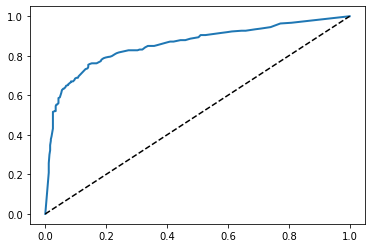

0.856909225929727

In [454]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

y_scores = cross_val_predict(pipe_out, X_train, y_train, cv=3,
                             method="predict_proba")
                             #method="decision_function") #SGD
    
y_scores = y_scores[:, 1]   # score = proba of positive class

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.show()
# forest
# 0.856909225929727
# 0.8557619297938204 drop age

# knn
# 0.8406051048420068

# sgd
# n/a

roc_auc_score(y_train, y_scores)

## Submission

In [468]:
lin_class_test = LinearRegression()
svc_class_test = SVC(random_state=42)
forest_class_test = RandomForestClassifier(random_state=42)
knn_class_test = KNeighborsClassifier()
sgd_class_test = SGDClassifier(random_state=42, shuffle=True)

In [493]:
grid_search_test = GridSearchCV(knn_class_test, knn_param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=1)

#col_trans.named_transformers_["cat"].handle_unknown = 'ignore' # for dropping attributes

main_pipeline_test = Pipeline([
    ('col', col_trans),
    ('dropper', AttributesDropper()),
    ('grid', grid_search_test)
])

full_pipeline_test = GridSearchCV(main_pipeline_test, param_drpr, cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=2)#, error_score='raise')

In [494]:
all_test_data = load_csv_as_pd("test.csv")
all_test_data_pp = preprocess_data(all_test_data)

X_train_all = all_train_data_pp.drop(target_label_col, axis=1)
y_train_all = all_train_data_pp[target_label_col].copy()

pipe_out_test = full_pipeline_test.fit(X_train_all, y_train_all)
print(full_pipeline_test.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.9s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.9s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.9s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.9s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.9s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......................dropper__min_importance=0.001; total time=   0.8s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..................

In [495]:
y_submission = pipe_out_test.predict(all_test_data_pp)
print(y_submission.shape)

df = pd.DataFrame(y_submission, columns=['Survived'])
df.insert(0, "PassengerId", all_test_data["PassengerId"], allow_duplicates=True)
df.to_csv("submission.csv", index=False)
df

(418,)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


1. 0.75119: forest trained on subset of train.csv
2. 0.75598: forest trained on all data
3. 0.77751: knn .0001 drop?
4. 0.72966: sgd
5. 0.77751: knn .0003 drop